In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
# import data from CA, CT, TX, FL, NY, NJ 
ca = pd.read_csv('data/ca_ev_registrations_public.csv')
# nj = pd.read_csv('data/nj_ev_registrations_public.csv')
# ny = pd.read_csv('data/ny_ev_registrations_public.csv')
# tx = pd.read_csv('data/tx_ev_registrations_public.csv')
# fl = pd.read_csv('data/fl_ev_registrations_public.csv')
# ct = pd.read_csv('data/ct_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Create Data frame with years and amount of registered vehicles in that year
ca_years = pd.DataFrame(ca['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])
ca_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 11 non-null     object
 1   Registered Vehicles  11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes


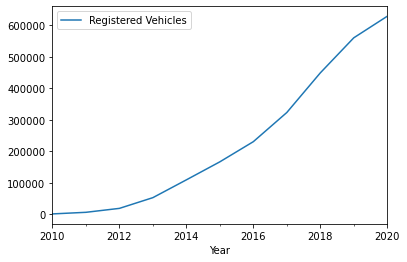

In [4]:
# As we can see, data is not stationary. 
ca_df = pd.DataFrame(ca_years['Registered Vehicles'])
ca_df = ca_df.set_axis(pd.to_datetime(ca_years['Year']))
ca_df.plot()
ca_df = ca_df.sort_values(by=['Registered Vehicles'], ascending = True)
ca_df = ca_df.astype(float)

In [5]:
# # interpolate then front fill 
# ca_dff = ca_df.resample('W').interpolate(method = 'linear')
# ca_dff.head()
# ca_dff.plot()


def ffbf(x):
    return x.interpolate().ffill().bfill()


            Registered Vehicles
Year                           
2010-01-03              18356.0
2010-01-10              18356.0
2010-01-17              18356.0
2010-01-24              18356.0
2010-01-31              18356.0


<AxesSubplot:xlabel='Year'>

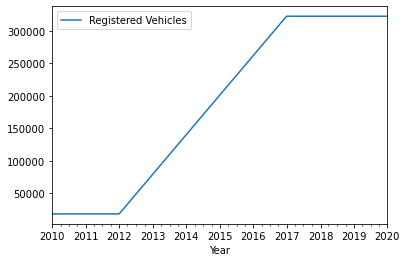

In [8]:
# interpolate then backfill
ca_dfb = ca_df.resample('W').interpolate(method = 'linear')
ca_dfb = ca_dfb.bfill()
print(ca_dfb.head())
ca_dfb.plot()


In [9]:
catestb = adfuller(ca_dfb)
display(catestb)
# pvalue - .314

(-1.9371440235526576,
 0.3147941109023367,
 1,
 521,
 {'1%': -3.4429638415440995,
  '5%': -2.867103482127635,
  '10%': -2.569733131582922},
 5750.818376441284)

# Modeling

In [10]:
catrain = ca_dfb['2010':'2018']
catest = ca_dfb['2019':'2020']
combined = ca_dfb

catest

,Registered Vehicles
Year,
2019-01-06,322762.0
2019-01-13,322762.0
2019-01-20,322762.0
2019-01-27,322762.0
2019-02-03,322762.0
2019-02-10,322762.0
2019-02-17,322762.0
2019-02-24,322762.0
2019-03-03,322762.0


In [11]:
auto_modelca = pm.auto_arima(catrain, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_modelca.summary())

# (2,0,1), (0,0,0) , [0]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12850.876, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7122.094, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5433.540, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5435.549, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5435.539, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6692.164, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5432.793, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7123.355, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5434.750, Time=0.54 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9979      0.100     19.965      0.000       1.802       2.194
ar.L2         -0.9980      0.100     -9.938      0.000      -1.195      -0.801
ma.L1         -0.0006      1.084     -0.001      1.000      -2.125       2.124
sigma2      5822.8302     79.328     73.402      0.000    5667.350    5978.310


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


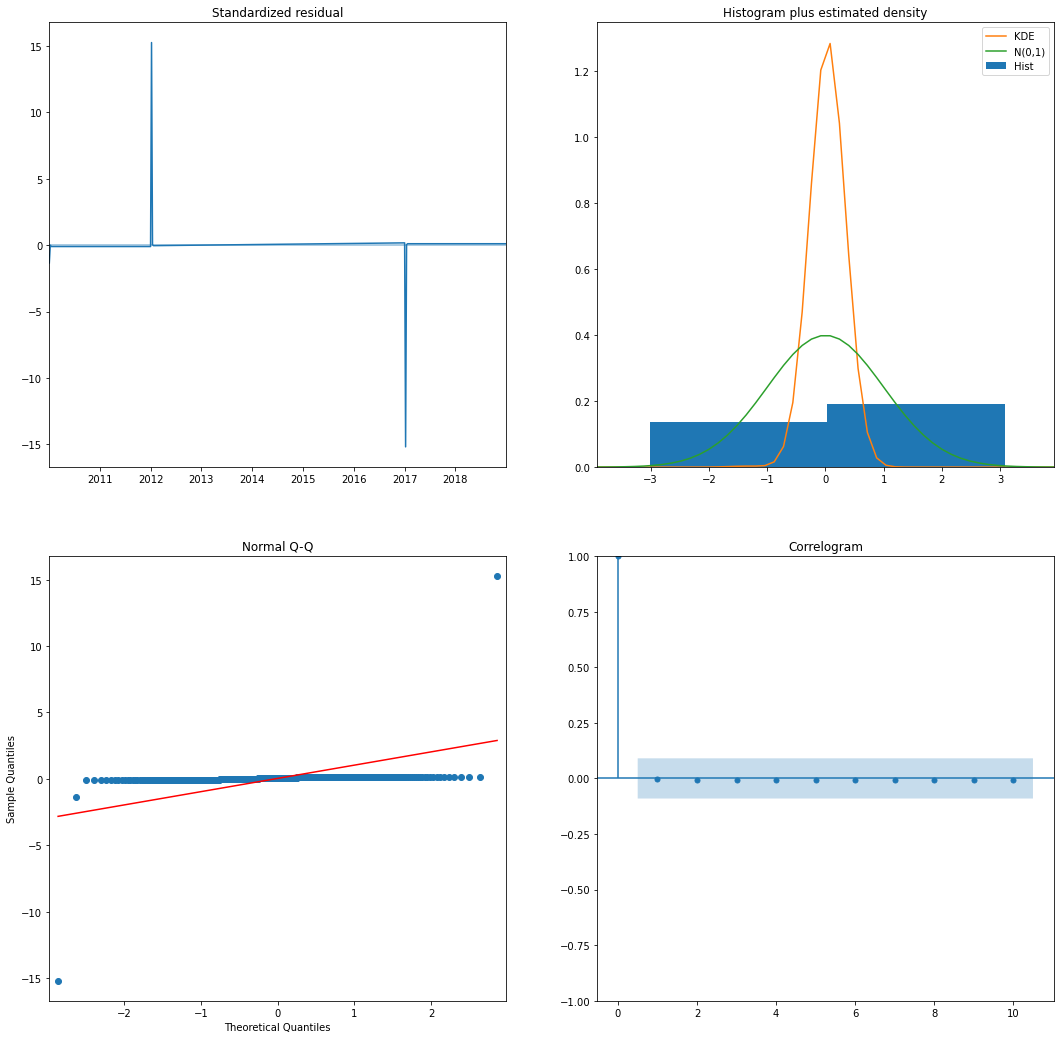

In [12]:
ARIMA_MODELCA = sm.tsa.statespace.sarimax.SARIMAX(catrain, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


outputca = ARIMA_MODELCA.fit()

print(outputca.summary().tables[1])
auto_modelca.plot_diagnostics(figsize=(18,18))
plt.show()

In [13]:
predca = outputca.get_prediction(start=pd.to_datetime('2019-01-06'), end=pd.to_datetime('2020-01-05'), dynamic=False)
pred_confca = predca.conf_int()
pred_confca

,lower Registered Vehicles,upper Registered Vehicles
2019-01-06,322608.506938,322907.626729
2019-01-13,322416.134719,323084.286866
2019-01-20,322179.921652,323296.958300
2019-01-27,321905.862192,323539.662834
2019-02-03,321598.003283,323808.369844
2019-02-10,321259.280428,324100.160211
2019-02-17,320891.945809,324412.798196
2019-02-24,320497.798937,324744.500791
2019-03-03,320078.321816,325093.802560
2019-03-10,319634.763766,325459.470807


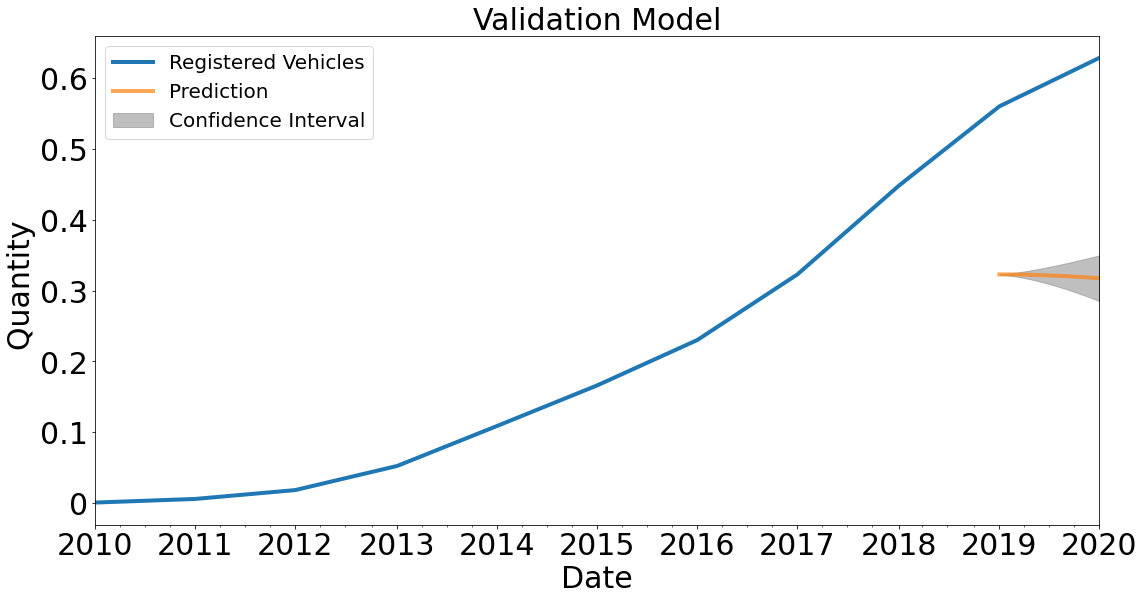

In [14]:


rcParams['figure.figsize'] = 18, 9
ax = ca_df.plot(label='observed', linewidth = 4)

predca.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.7, linewidth = 4)


ax.fill_between(pred_confca.index,
                pred_confca.iloc[:, 0],
                pred_confca.iloc[:, 1], color='grey', alpha=0.5,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity ',fontsize=30)
plt.yticks(fontsize=30)
#Changing the y scale to ($) Millions
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [ ]:

# ca_df.head()

In [ ]:
# Differencing to be stationary 
# ca_diff = ca_df.diff().dropna()
# ca_diff.plot()

In [ ]:
cadifftest = adfuller(ca_diff)
display(cadifftest)
# Pvalue -  0.9754235581948372

In [ ]:

# plot_acf(ca_diff, ax=ax, lags = 3)

#### Lets take the necessary data from each of the data frames - specifically date, and convert them into a usable format as they are currently 'objects' and need them to be in datetime format for analyses